In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Tensorflow-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models


In [2]:
!python --version

Python 3.12.12


In [3]:
!pip install albumentations --no-deps

In [4]:
!pip install segmentation-models --no-deps

In [ ]:
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.1.1

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import random
import cv2
import numpy as np
print(np.__version__)
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm
sm.set_framework('tf.keras')

2.0.2
3.10.0
2.19.0
Segmentation Models: using `keras` framework.


In [3]:
DATA_DIR = '/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/'

x_train_dir = os.path.join(DATA_DIR, 'images/train')
y_train_dir = os.path.join(DATA_DIR, 'semantic_masks/train')

x_valid_dir = os.path.join(DATA_DIR, 'images/valid')
y_valid_dir = os.path.join(DATA_DIR, 'semantic_masks/valid')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    CLASSES = ["Grasper", "Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        #self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, os.path.splitext(image_id)[0] + ".png") for image_id in self.ids]

        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls) for cls in classes]
        self.class_values = [self.CLASSES.index(cls) + 1 for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        while True:
            image = cv2.imread(self.images_fps[i])
            mask  = cv2.imread(self.masks_fps[i], 0)

            # skip bad image or mask
            if image is None or mask is None:
                i = (i + 1) % len(self.ids)
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            break

        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype("float")
        mask = np.stack(masks, axis=-1).astype(np.float32)

        # add background
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.ids)

class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        #return batch
        return tuple(batch)

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

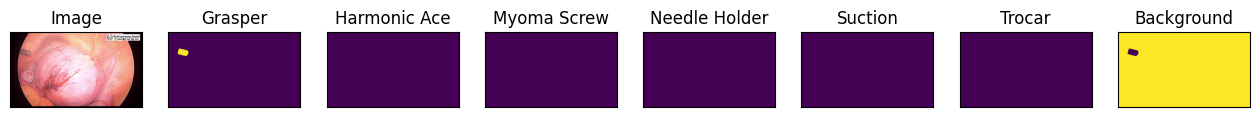

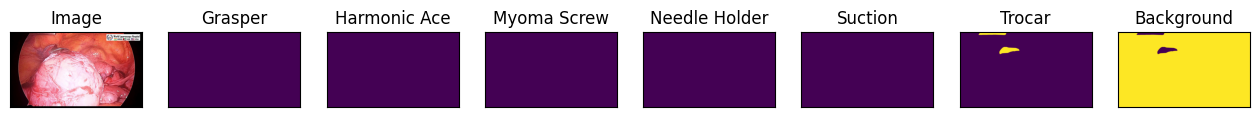

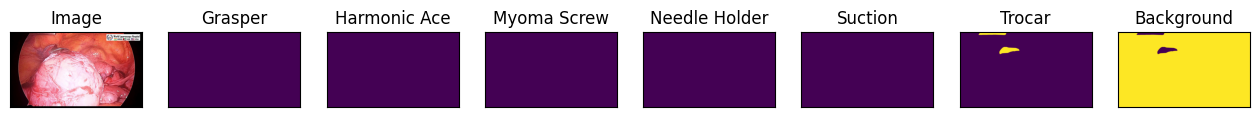

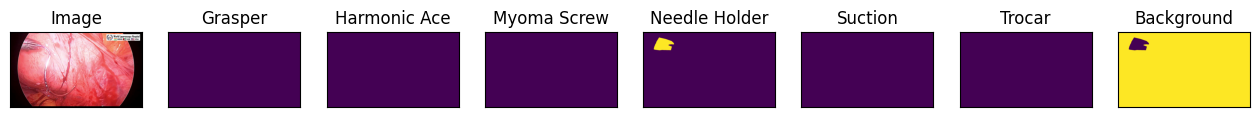

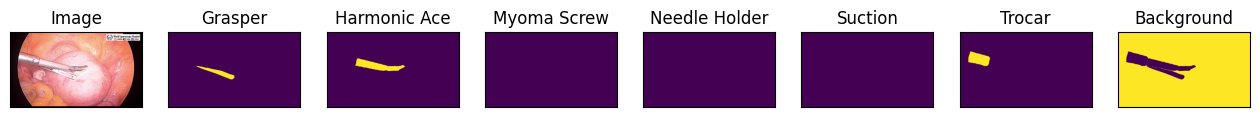

In [9]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=["Grasper", "Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"])

for i in range(5):
# for i in range(5,10):
    image, mask = dataset[i]
    visualize(
        image=image,
        grasper=mask[..., 0],
        harmonic_ace=mask[..., 1],
        myoma_screw=mask[..., 2],
        needle_holder=mask[..., 3],
        suction=mask[..., 4],
        trocar=mask[..., 5],
        background=mask[..., 6],
    )

In [5]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.Resize(512, 512),

        A.HorizontalFlip(p=0.5),

        A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-15, 15), p=0.5),

        A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=0.2),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(512, 512),
        A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

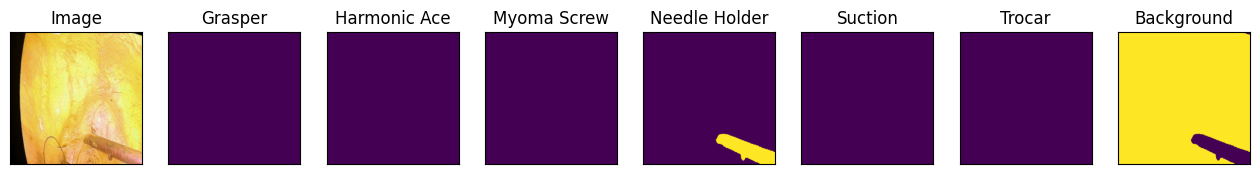

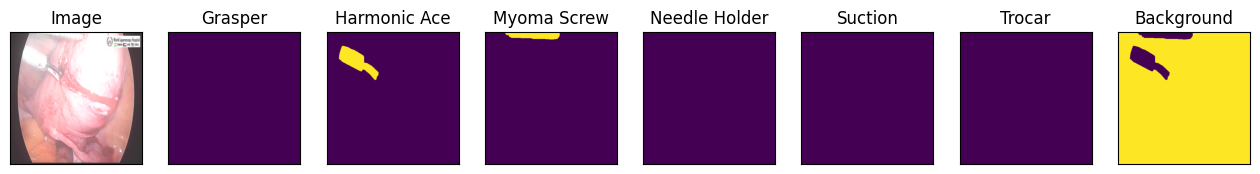

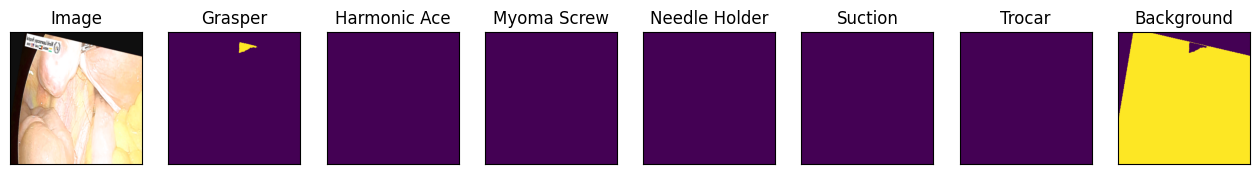

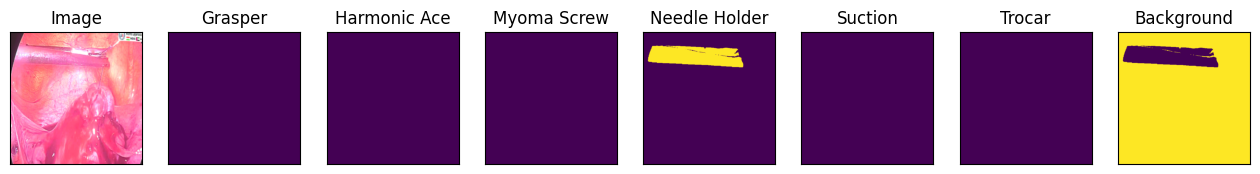

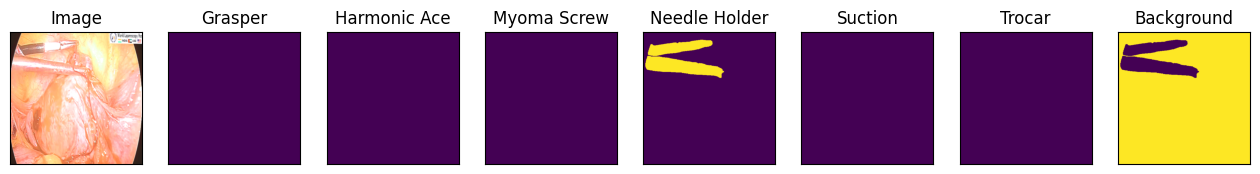

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=["Grasper", "Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"], augmentation=get_training_augmentation())

for i in range(5,10):
    image, mask = dataset[i]
    visualize(
        image=image,
        grasper=mask[..., 0],
        harmonic_ace=mask[..., 1],
        myoma_screw=mask[..., 2],
        needle_holder=mask[..., 3],
        suction=mask[..., 4],
        trocar=mask[..., 5],
        background=mask[..., 6],
    )

In [6]:
BACKBONE = 'resnet50' #'resnet34'
BATCH_SIZE = 12
CLASSES = ["Grasper", "Harmonic_Ace", "Myoma_Screw", "Needle_Holder", "Suction", "Trocar"]
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
print(n_classes)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

7


In [14]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_18   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_1… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_19   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 32,561,984 (124.21 MB)

 Trainable params: 32,514,426 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [8]:
# define optomizer
# optim = tf.keras.optimizers.Adam(LR)
optim = tf.keras.optimizers.Adam(1e-5)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5]))
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1, 1, 1, 1, 0.2]))
focal_loss = sm.losses.CategoricalFocalLoss()

def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [9]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

In [10]:
def generator():
    for i in range(len(train_dataloader)):
        yield train_dataloader[i]

def valid_generator():
    for i in range(len(valid_dataloader)):
        yield valid_dataloader[i]

output_signature = (
    tf.TensorSpec(shape=(BATCH_SIZE, 512, 512, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, 512, 512, n_classes), dtype=tf.float32),
)

train_tf_dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature,
).prefetch(tf.data.AUTOTUNE)

valid_tf_dataset = tf.data.Dataset.from_generator(
    valid_generator,
    output_signature=output_signature,
).prefetch(tf.data.AUTOTUNE)

In [11]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('SM_UNet_SIS.weights.h5', save_weights_only=True, save_best_only=True, monitor="val_iou_score", mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history1 = model.fit(
    train_tf_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_tf_dataset,
)

Epoch 1/10
    237/Unknown 4123s 17s/step - f1-score: 0.2455 - iou_score: 0.2110 - loss: 0.9755

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


237/237 ━━━━━━━━━━━━━━━━━━━━ 5393s 22s/step - f1-score: 0.2460 - iou_score: 0.2114 - loss: 0.9754 - val_f1-score: 0.3220 - val_iou_score: 0.2957 - val_loss: 0.9570 - learning_rate: 1.0000e-04
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 873s 4s/step - f1-score: 0.3733 - iou_score: 0.3320 - loss: 0.9009 - val_f1-score: 0.3928 - val_iou_score: 0.3587 - val_loss: 0.9293 - learning_rate: 1.0000e-04
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 866s 4s/step - f1-score: 0.4265 - iou_score: 0.3795 - loss: 0.8380 - val_f1-score: 0.3911 - val_iou_score: 0.3355 - val_loss: 0.8445 - learning_rate: 1.0000e-04
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 869s 4s/step - f1-score: 0.4260 - iou_score: 0.3670 - loss: 0.8066 - val_f1-score: 0.4151 - val_iou_score: 0.3690 - val_loss: 0.8172 - learning_rate: 1.0000e-04
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - f1-score: 0.4820 - iou_score: 0.4222 - loss: 0.7888 - val_f1-score: 0.4183 - val_iou_score: 0.3616 - val_loss: 0.8020 - learning_rate: 1.0000e-04
Epoc

In [ ]:
history2 = model.fit(
    train_tf_dataset,
    epochs=5,
    callbacks=callbacks,
    validation_data=valid_tf_dataset,
)

Epoch 1/5
    237/Unknown 6565s 27s/step - f1-score: 0.5125 - iou_score: 0.4407 - loss: 0.7053

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


237/237 ━━━━━━━━━━━━━━━━━━━━ 8231s 34s/step - f1-score: 0.5127 - iou_score: 0.4408 - loss: 0.7052 - val_f1-score: 0.5978 - val_iou_score: 0.5327 - val_loss: 0.6078 - learning_rate: 1.0000e-05
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 916s 4s/step - f1-score: 0.5349 - iou_score: 0.4642 - loss: 0.6813 - val_f1-score: 0.6116 - val_iou_score: 0.5478 - val_loss: 0.6019 - learning_rate: 1.0000e-05
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 904s 4s/step - f1-score: 0.5522 - iou_score: 0.4825 - loss: 0.6700 - val_f1-score: 0.6089 - val_iou_score: 0.5460 - val_loss: 0.5959 - learning_rate: 1.0000e-05
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - f1-score: 0.5586 - iou_score: 0.4907 - loss: 0.6627 - val_f1-score: 0.6189 - val_iou_score: 0.5570 - val_loss: 0.5924 - learning_rate: 1.0000e-05
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 911s 4s/step - f1-score: 0.5699 - iou_score: 0.5021 - loss: 0.6527 - val_f1-score: 0.6221 - val_iou_score: 0.5606 - val_loss: 0.5890 - learning_rate: 1.0000e-05


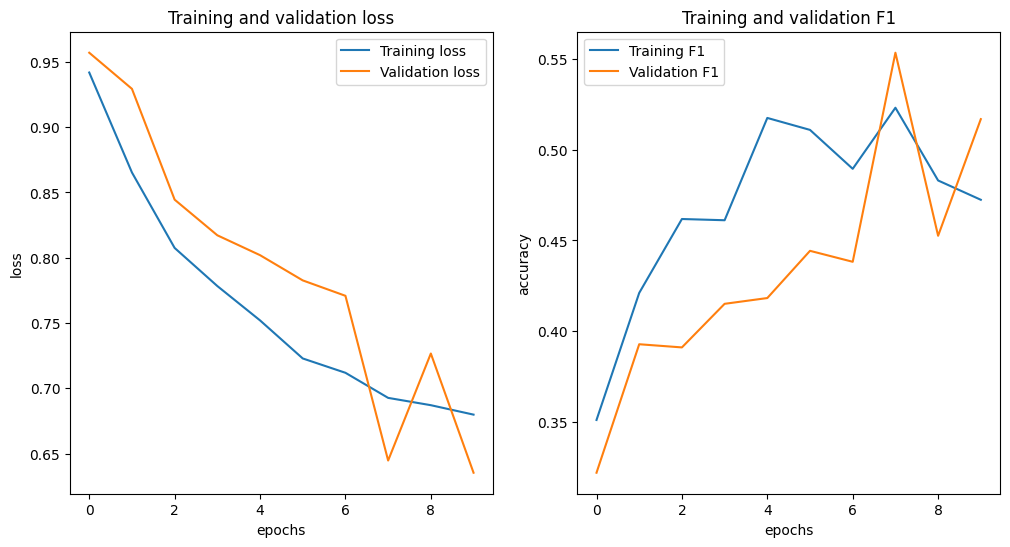

In [ ]:
'''Plots the training and validation loss and accuracy from a history object'''
loss = history1.history['loss']
val_loss = history1.history['val_loss']
accuracy = history1.history['f1-score']
val_accuracy = history1.history['val_f1-score']

epochs = range(len(loss))

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(epochs, loss, label='Training loss')
ax[0].plot(epochs, val_loss, label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(epochs, accuracy, label='Training F1')
ax[1].plot(epochs, val_accuracy, label='Validation F1')
ax[1].set_title('Training and validation F1')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

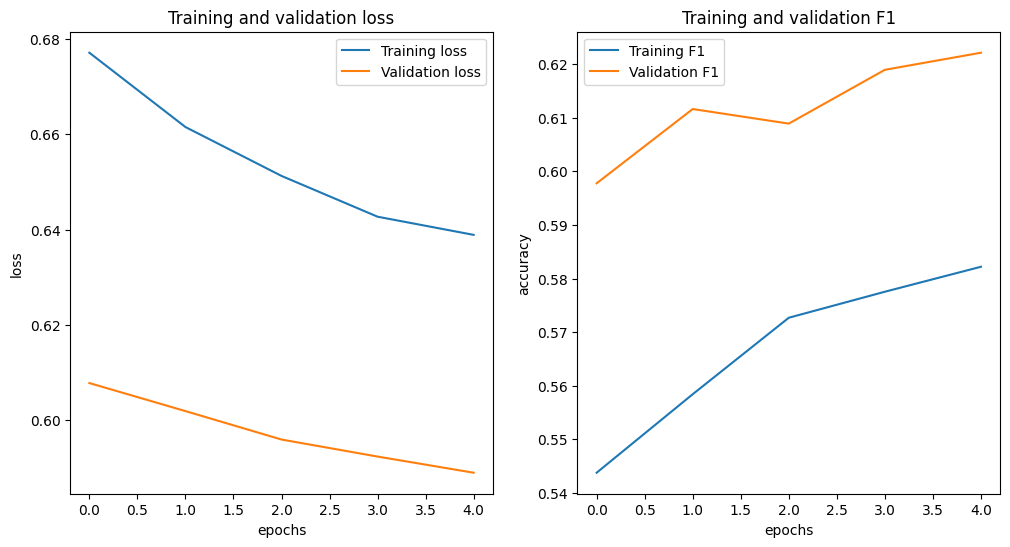

In [ ]:
'''Plots the training and validation loss and accuracy from a history object'''
loss = history2.history['loss']
val_loss = history2.history['val_loss']
accuracy = history2.history['f1-score']
val_accuracy = history2.history['val_f1-score']

epochs = range(len(loss))

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(epochs, loss, label='Training loss')
ax[0].plot(epochs, val_loss, label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(epochs, accuracy, label='Training F1')
ax[1].plot(epochs, val_accuracy, label='Validation F1')
ax[1].set_title('Training and validation F1')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()

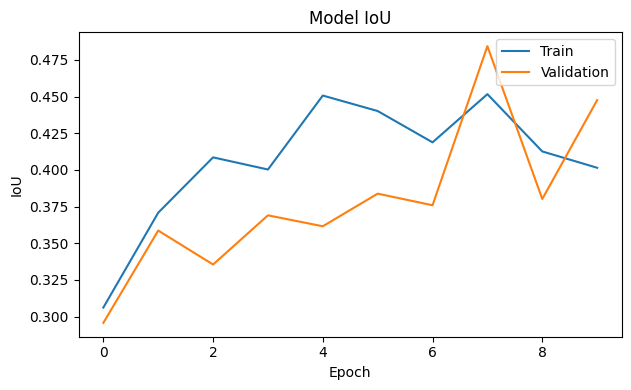

In [ ]:
meaniou = history1.history['iou_score']
val_meaniou = history1.history['val_iou_score']

plt.figure(figsize=(12, 4))
# Plot training & validation mean iou values
plt.subplot(1, 2, 2)
plt.plot(meaniou)
plt.plot(val_meaniou)
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

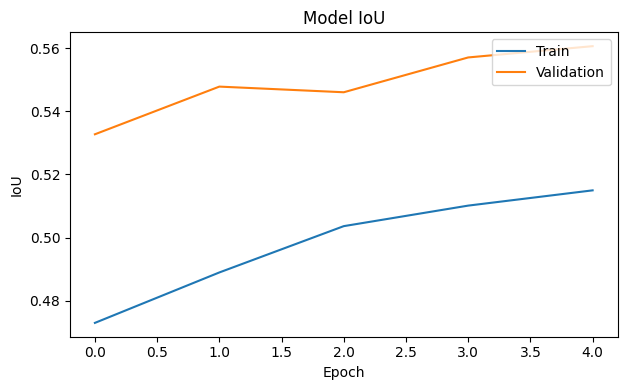

In [ ]:
meaniou = history2.history['iou_score']
val_meaniou = history2.history['val_iou_score']

plt.figure(figsize=(12, 4))
# Plot training & validation mean iou values
plt.subplot(1, 2, 2)
plt.plot(meaniou)
plt.plot(val_meaniou)
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
model.load_weights('SM_UNet_SIS.weights.h5')

In [ ]:
scores = model.evaluate(valid_tf_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

70/70 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - f1-score: 0.5051 - iou_score: 0.4430 - loss: 0.6880
Loss: 0.64472
mean iou_score: 0.48438
mean f1-score: 0.55344


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [21]:
scores = model.evaluate(valid_tf_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

70/70 ━━━━━━━━━━━━━━━━━━━━ 1230s 17s/step - f1-score: 0.5878 - iou_score: 0.5311 - loss: 0.6375
Loss: 0.58897
mean iou_score: 0.56058
mean f1-score: 0.62214


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


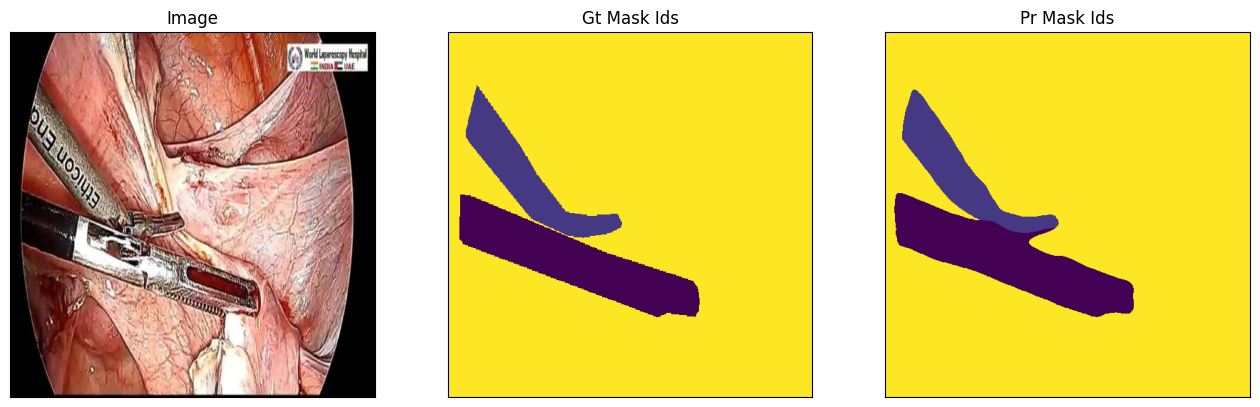

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


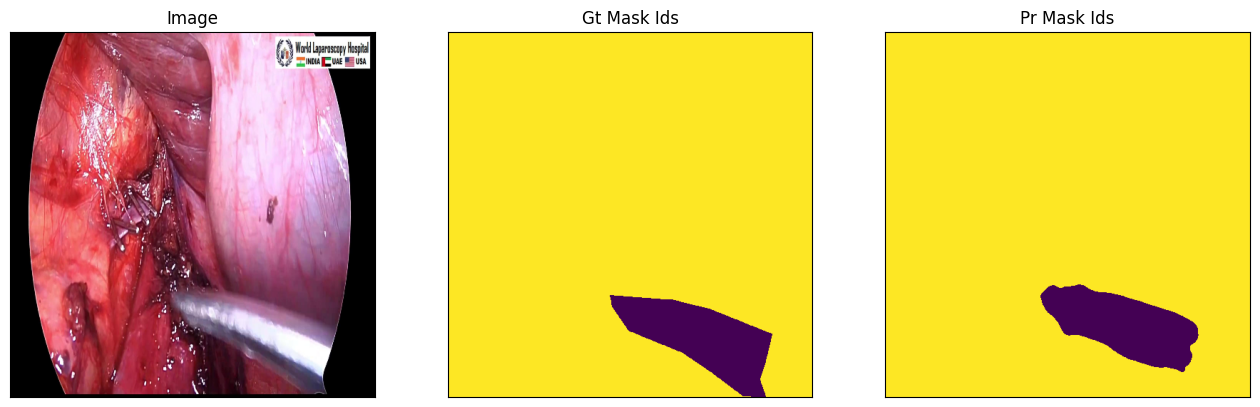

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


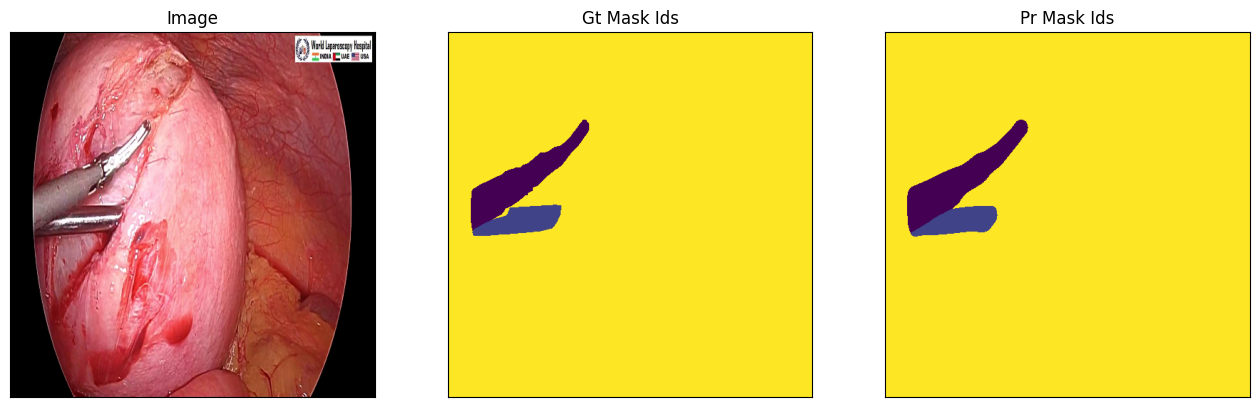

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


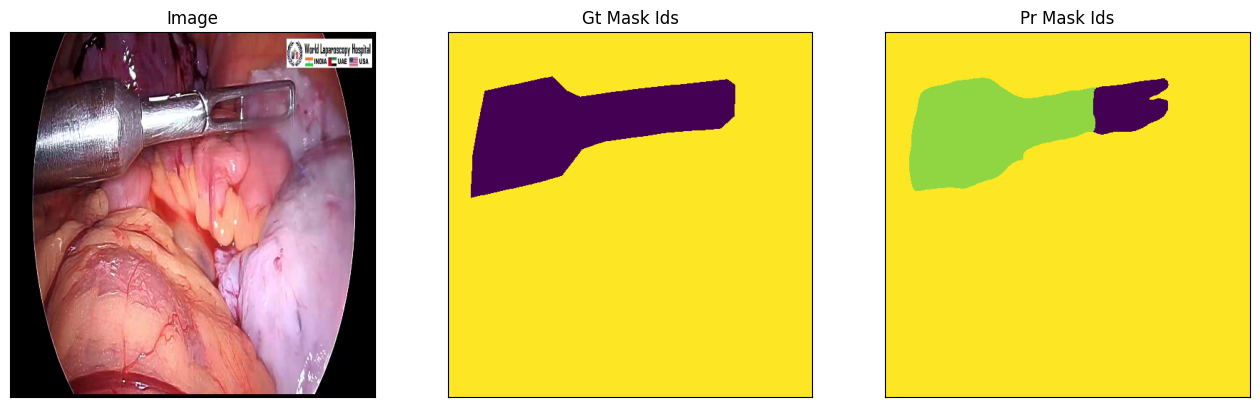

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


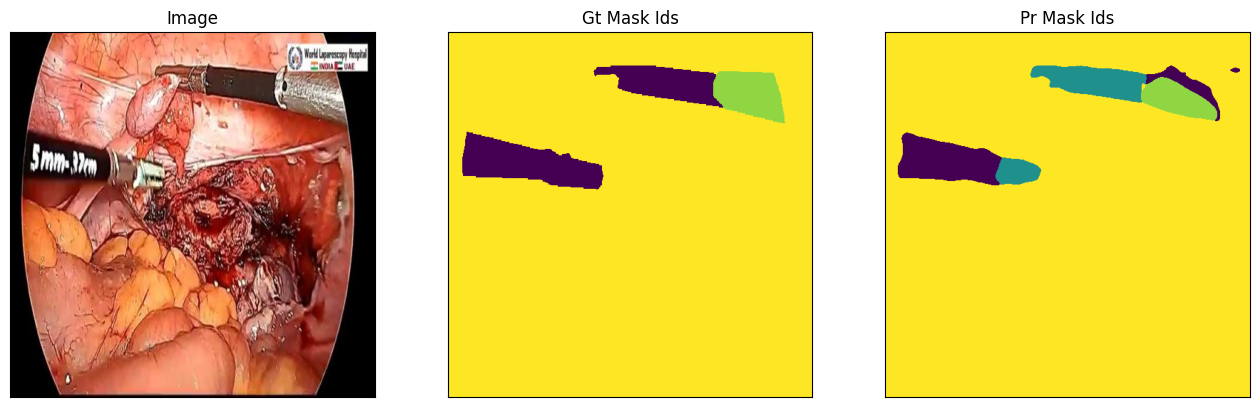

In [25]:
n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)

    # Convert 7-channel ground truth mask to a single-channel mask (class IDs)
    gt_mask_single_channel = np.argmax(gt_mask.squeeze(), axis=-1)

    # Convert 7-channel predicted mask to a single-channel mask (class IDs)
    pr_mask_single_channel = np.argmax(pr_mask.squeeze(), axis=-1)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_ids=gt_mask_single_channel, # Display as grayscale based on class ID
        pr_mask_ids=pr_mask_single_channel, # Display as grayscale based on class ID
    )

In [14]:
id2color = {
    6: (0, 0, 0),          # background - black
    0: (255, 0, 0),        # red
    1: (0, 255, 0),        # green
    2: (0, 0, 255),        # blue
    3: (255, 255, 0),      # yellow
    4: (255, 0, 255),      # magenta
    5: (0, 255, 255),      # cyan
}

In [15]:
def num_to_rgb(num_arr, color_map=id2color):

    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [16]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

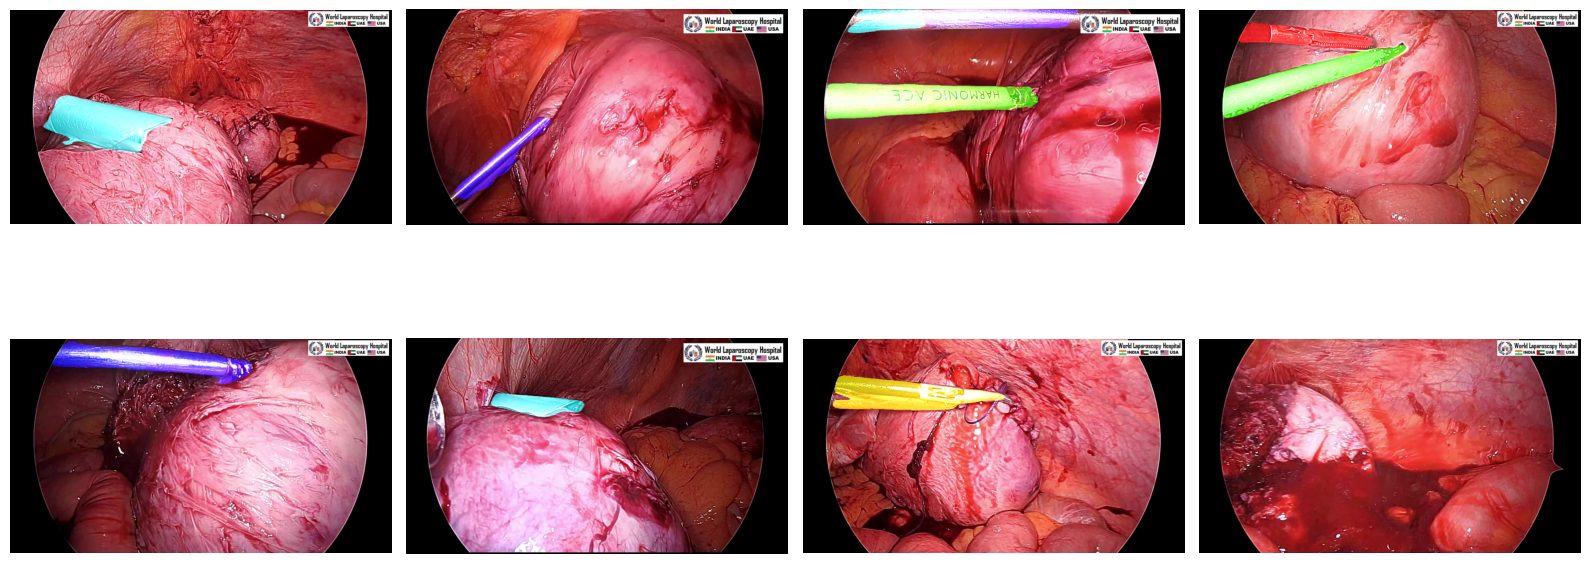

In [63]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32))

model_images = np.array(model_images)

# ---------------- INFERENCE ----------------
probs = model.predict(model_images, verbose=0)

top2 = np.partition(probs, -2, axis=-1)[..., -2:]
conf_gap = top2[..., 1] - top2[..., 0]

pred = np.argmax(probs, axis=-1)
pred[conf_gap < CONF_GAP] = 0

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Serialize the model as a SavedModel.
# Use model.export for Keras models
model.export("SM_UNet_SIS")

# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("SM_UNet_SIS")

# Enable TF Select ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TF Select ops
]

# No optimizations
tflite_model = converter.convert()
open("SM_UNet_SIS.tflite", "wb").write(tflite_model)

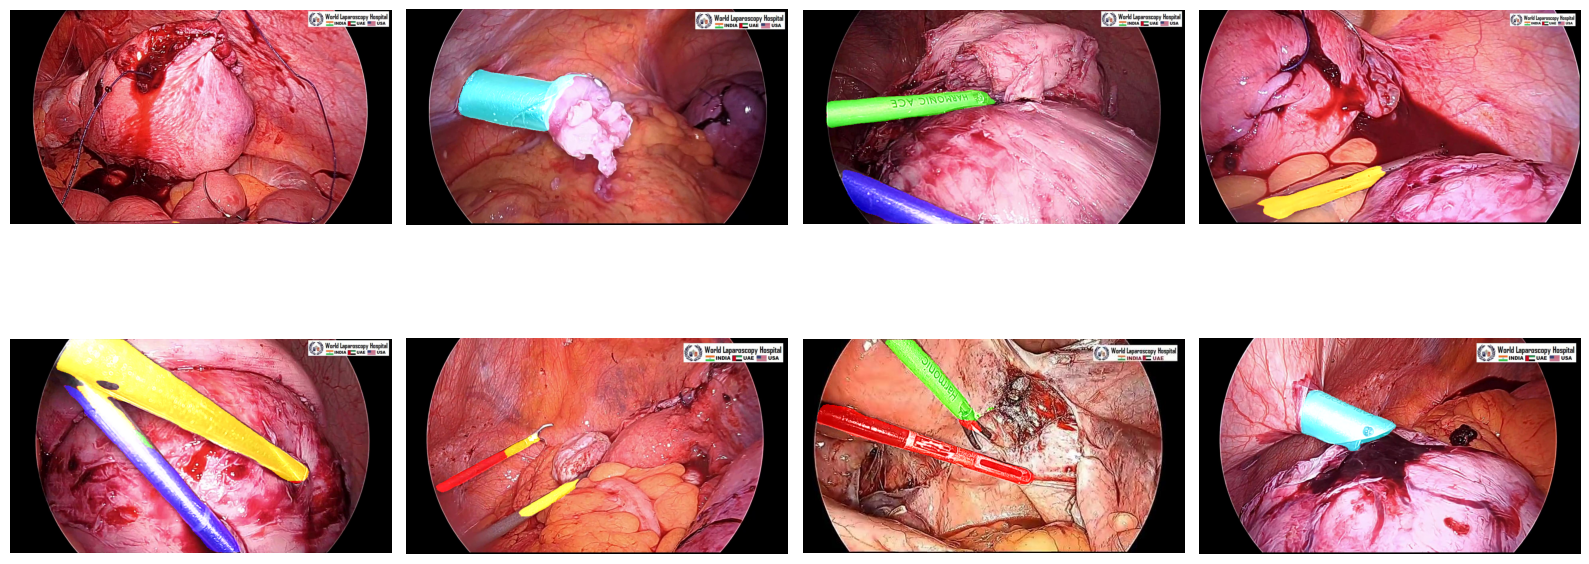

In [78]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# ---------- LOAD TFLITE ----------
interpreter = tf.lite.Interpreter(
    model_path="SM_UNet_SIS.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ---- FIX MODEL INPUT SHAPE (ONCE) ----
MODEL_H = 512   # MUST match training
MODEL_W = 512

interpreter.resize_tensor_input(
    input_details[0]["index"],
    [1, MODEL_H, MODEL_W, 3],
    strict=True
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32))

model_images = np.array(model_images)

# ---------------- INFERENCE (TFLITE, SINGLE IMAGE) ----------------
all_preds = []

for img in model_images:
    # add batch dimension
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]["index"], input_tensor)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]["index"])  # (1, 512, 512, C)
    all_preds.append(output[0])  # remove batch dim

probs = np.array(all_preds)  # (N, 512, 512, C)

top2 = np.partition(probs, -2, axis=-1)[..., -2:]
conf_gap = top2[..., 1] - top2[..., 0]

pred = np.argmax(probs, axis=-1)
pred[conf_gap < CONF_GAP] = 0

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install tf2onnx onnx onnxruntime

In [17]:
import tf2onnx
import tensorflow as tf

# 1. Define the input signature
spec = (tf.TensorSpec((None, 512, 512, 3), tf.float32, name="input"),)

# 2. Convert the model
output_path = "SM_UNet_SIS.onnx"

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13, # Standard version for compatibility
    output_path=output_path
)

print(f"SUCCESS! Your model is saved as {output_path}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7bc5d5c4ab60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


SUCCESS! Your model is saved as SM_UNet_SIS.onnx


In [18]:
import onnxruntime as ort
import numpy as np

session = ort.InferenceSession("SM_UNet_SIS.onnx")
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

dummy_input = np.random.rand(1, 512, 512, 3).astype(np.float32)

outputs = session.run(None, {input_name: dummy_input})

print(len(outputs))
for o in outputs:
    print(o.shape)

1
(1, 512, 512, 7)


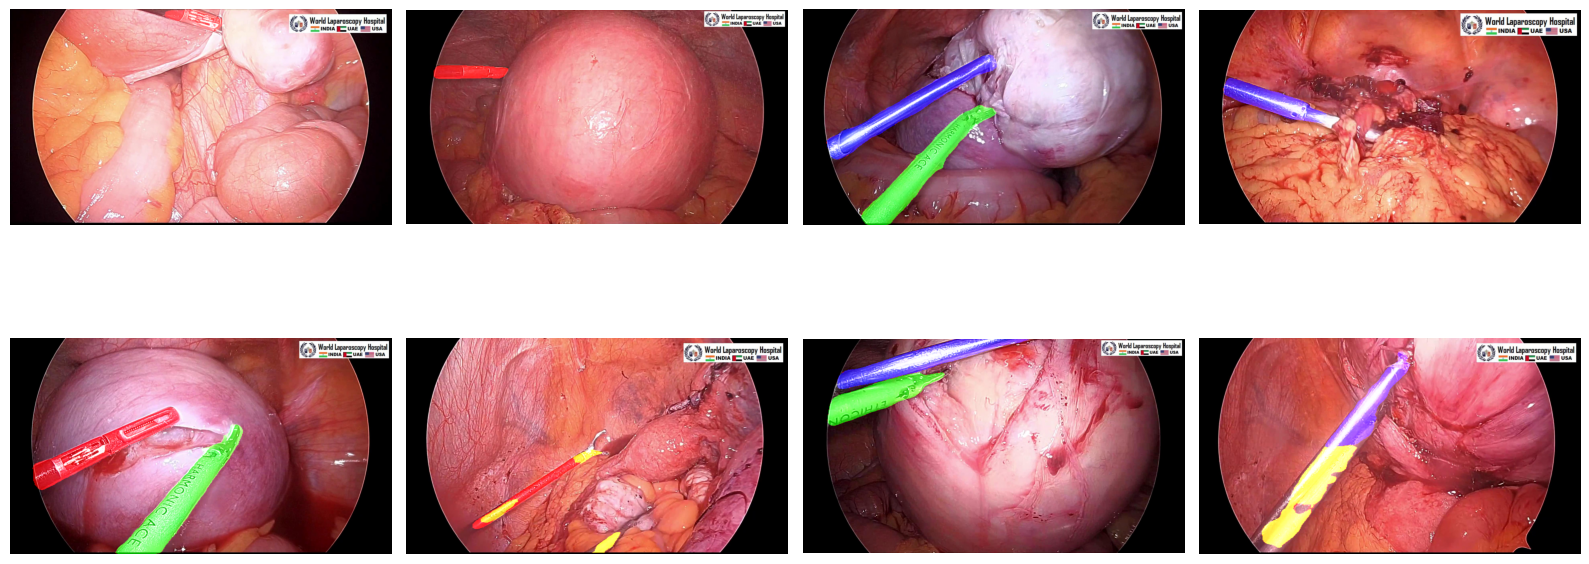

In [19]:
import os, random, cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Tensorflow-Models/datasets/surgical_instruments/images/valid"

N = 8
cols = 4
rows = int(np.ceil(N / cols))
CONF_GAP = 0.1
INPUT_SIZE = (512, 512)
# ----------------------------------------

# ---------- LOAD ONNX ----------
session = ort.InferenceSession("SM_UNet_SIS.onnx")
input_name  = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]

# collect images
all_imgs = [
    os.path.join(val_dir, f)
    for f in os.listdir(val_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

sample_imgs = random.sample(all_imgs, N)

# ---------------- LOAD IMAGES ----------------
orig_images = []
model_images = []
orig_sizes = []

for p in sample_imgs:
    img_bgr = cv2.imread(p)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w = img_rgb.shape[:2]
    orig_sizes.append((h, w))
    orig_images.append(img_rgb)

    img_resized = cv2.resize(img_rgb, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
    model_images.append(img_resized.astype(np.float32))

model_images = np.array(model_images)

# ---------- RUN ONNX INFERENCE ----------
preds = []

for img in model_images:
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)

    probs = session.run(
        output_names,
        {input_name: input_tensor}
    )[0][0]  # (512, 512, C)

    # confidence gap (IMMEDIATELY)
    top2 = np.partition(probs, -2, axis=-1)[..., -2:]
    conf_gap = top2[..., 1] - top2[..., 0]

    pred = np.argmax(probs, axis=-1)
    pred[conf_gap < CONF_GAP] = 0

    preds.append(pred.astype(np.uint8))

    # IMPORTANT: free memory explicitly
    del probs, top2, conf_gap

pred = np.array(preds)  # (N, 512, 512)

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (img, pr, (h, w)) in enumerate(zip(orig_images, pred, orig_sizes)):
    # resize prediction back to original image size
    pr_resized = cv2.resize(
        pr.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    rgb_pred = num_to_rgb(pr_resized, color_map=id2color)
    overlay = image_overlay(img, rgb_pred)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()